
参考サイト：https://github.com/teddylee777/langchain-kr/blob/main/12-RAG/10-Multi_modal_RAG-GPT-4o.ipynb
・韓国語ですので翻訳して読んでください

Retrieval-Augmented Generation
text, image, video, audio などのいろんな形のデータを同時に処理して情報検索、生成するシステム
inputが検索 Augmented Retrieval
outPutが Generation

option1
資源のイメージ、テキストを inputしてoutPutを取得

option2
イメージからテキストを取得して image + summery, text inputしてoutPutを取得

option3(gpt4o)
Gptなどを利用してイメージからテキストを取得、資源イメージと資源イメージから取得したテキスト、送るテキストなどを利用してoutPutを取得

適切なtextとイメージを利用してoutPutを取得する

GPT-4oの場合、イメージはbase64ファイルとして受け取って解釈する。


課題
・イメージを要約するためのprompt、テキストを分析するためのprompt、query → この部分を改善して行く。
・文字列がdragできない完璧なイメージファイル（テーブルがある?）をテストする。->
・システムとしてはどの形で実装するべきかを考える。

In [48]:
! pip install -U langchain openai chromadb langchain-experimental 


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [47]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [67]:
fpath = "tmp/image/"
# fname = "test2.pdf"

In [69]:
import base64
import os
from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage


def encode_image(image_path):
    # イメージファイルをbase64にencodingする。
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    # イメージの要約を生成する。
    chat = ChatOpenAI(model="gpt-4o", max_tokens=2048)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


# イメージに対した要約とbase64encodingの文字列を生成する。
# path: Unstructuredによって取った .jpgファイルのpath
def generate_img_summaries(path):

    # base64にencodingされたイメージを保存するリスト
    img_base64_list = []

    # イメージの要約を保存するリスト
    image_summaries = []

    # 要約のためのprompt　 ！！！！！！！！！！！！！！！！！！！！
    prompt = """保険に対した情報を集めてください。"""

    # イメージに適用
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".png"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# イメージの要約実行
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [70]:
len(image_summaries)

5

In [72]:
import uuid


from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import OpenAIEmbeddings

# 要約をindexかする、資源イメージ、テキストをreturnする検索機を生成する。
def create_multi_vector_retriever(vectorstore, image_summaries, images):

    # 保存storage初期化
    store = InMemoryStore()
    id_key = "doc_id"

    # multi vector 検索機生成
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 文書をvector保存先と文書保存先に追加するhelper関数
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]  # 文書毎の固有なID生成
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 要約文書をvector保存先に追加、原本をdocstoreに保存する、queryに対して実際参考する
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 要約文書を文書保存先に追加、要約をvectorstoreに保存する、類似有無を確認するための要約データ

    # テキストとテーブルデータはないためコメントアウト
    # if text_summaries:
    #     add_documents(retriever, text_summaries, texts)

    # if table_summaries:
    #     add_documents(retriever, table_summaries, tables)

    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [73]:
# 要約をindex化するためのvector保存先
vectorstore = Chroma(
    collection_name="sample-rag-multi-modal", embedding_function=OpenAIEmbeddings()
)

# 検索機生成
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    image_summaries,
    img_base64_list,
)

In [74]:
import io
import re

from langchain_core.output_parsers import StrOutputParser
from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    # base64にencodingされた文字列をイメージに表示
    # base64文字列をsourceにするHTML imgタグを生成
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTMLレンダーしてイメージを表示
    display(HTML(image_html))


def looks_like_base64(sb):
    # 文字列がbase64で見えるかを確認
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    # base64データが　イメージかを始まりを見て確認
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 最初の8ビッドをdecodeする
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


# base64文字列のイメージをsize調節
# イメージを調節する。このイメージのサイズによっても検索する際、性能の差がある　！！！！！！！！！！！！！！！！！！！！！！
def resize_base64_image(base64_string, size=(128, 128)):

    # Base64 文字列decode
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # イメージのサイズ調節
    resized_img = img.resize(size, Image.LANCZOS)

    # 調節されたイメージをbufferに保存
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 調節されたイメージををencoding
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


# base64にencodingされたイメージとテキストを分離
def split_image_text_types(docs):

    b64_images = []
    texts = []
    for doc in docs:
        # 文書がDocumentタイプの場合page_contentを取る
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


# contextを一個の文字列として結合
def img_prompt_func(data_dict):
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # イメージがあればメッセージに追加
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 分析のためのテキスト追加　！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    text_message = {
        "type": "text",
        "text": (
            "これは保険書類です。\n"
            "あなたは何時もイメージファイルをもらいます。\n"
            "この保険証類を要約して日本語で書いで回答してください。\n"
            f"質問: {data_dict['question']}\n\n"
            f"{formatted_texts}"
            # "text": (
            #     "You are financial analyst tasking with providing investment advice.\n"
            #     "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            #     "Use this information to provide investment advice related to the user question. Answer in Japanese. Do NOT translate company names.\n"
            #     f"User-provided question: {data_dict['question']}\n\n"
            #     "Text and / or tables:\n"
            #     f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


# multiModal Rag チェイン
def multi_modal_rag_chain(retriever):

    # multiModal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG パイプライン
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG チェイン生成
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [75]:
# 検索実行　　！！！！！！！！！！！！！！！！！！！！！！！！！
query = "この保険書類のグラフの特徴を教えてください。"

# queryに対した文書を6個取得
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 文書の数確認
len(docs)

2

In [77]:
# 検索結果確認　　！！！！！！！！！！！！！！！！！！！！！！！！！
query = "この保険書類に対した特徴を教えてください。"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 文書の数確認
len(docs)

2


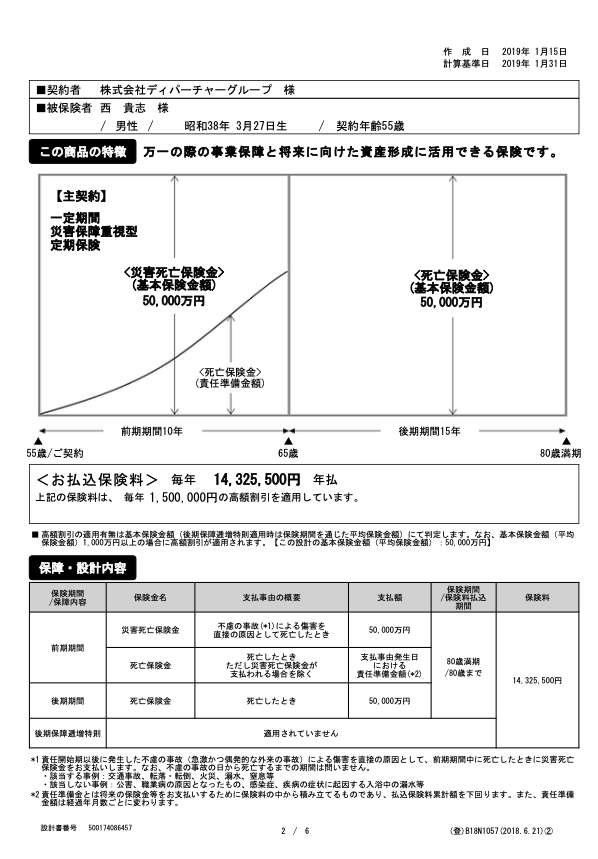

In [78]:
# 関連イメージをreturn
plt_img_base64(docs[0])


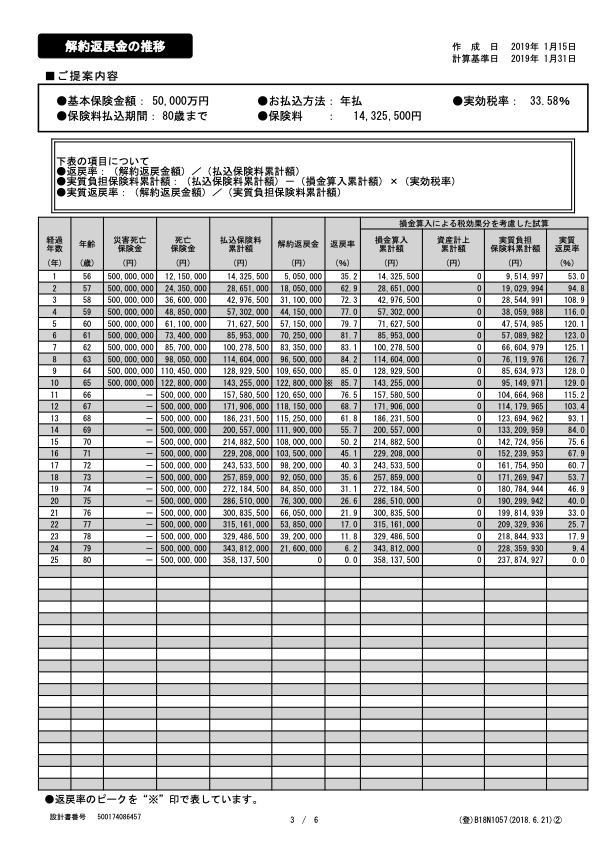

In [80]:
# img_base64_listリストの2番indexイメージをbase64形式に変換.
plt_img_base64(img_base64_list[2])

In [81]:
image_summaries[2]

'以下は、画像から読み取れる保険に関する情報です。\n\n### ご提案内容\n- **基本保険金額**: 50,000万円\n- **お払込方法**: 年払\n- **保険料払込期間**: 80歳まで\n- **保険料**: 14,325,500円\n- **実効税率**: 33.58％\n  \n### 解約返戻金の推移\n- **作成年**: 2019年1月15日\n- **計算基準日**: 2019年1月31日\n\n### 用語解説\n- **保険料累計**: 支払い続けた保険料の総額\n- **死亡保険金**: 被保険者が死亡した場合に支払われる金額\n- **払込保険料累計**: 現在までに支払った保険料の総額\n- **特別保険料累計**: 特定の条件下で追加で支払った保険料\n- **返戻金**: 保険を解約した場合に返ってくるお金\n- **返戻率**: 支払った保険料に対して返ってくるお金の割合\n- **課税対象額**: 税金がかかる金額\n- **控除後課税対象額**: 控除を適用した後の課税対象額\n\n### 年齢別の保険情報抜粋\n- **年齢30歳**: \n  - 保険料累計: 1,198,000円\n  - 死亡保険金: 50,000万円\n  - 返戻金: 0円\n  - 返戻率: 0%\n  \n- **年齢40歳**: \n  - 保険料累計: 5,990,000円\n  - 死亡保険金: 50,000万円\n  - 返戻金: 4,976,500円\n  - 返戻率: 83%\n  \n- **年齢50歳**: \n  - 保険料累計: 10,600,000円\n  - 死亡保険金: 50,000万円\n  - 返戻金: 8,593,500円\n  - 返戻率: 81%\n\n- **年齢60歳**: \n  - 保険料累計: 14,325,500円\n  - 死亡保険金: 50,000万円\n  - 返戻金: 12,800,000円\n  - 返戻率: 89%\n\n- **年齢70歳**: \n  - 保険料累計: 14,325,500円\n  - 死亡保険金: 50,000万円\n  - 返戻金: 22,900,000円\n  - 返戻率: 160%\n\n- **年齢80歳**: \n  - 保険料累計: 14,3

In [82]:
# RAGチェイン実行
print(chain_multimodal_rag.invoke(query))

この保険書類は、株式会社ディーパーチャーグループが契約者であり、被保険者は男性で昭和38年3月27日生まれの方です。契約年齢は55歳です。この保険の特徴は、事業保険と将来に向けた資産形成に活用できる点です。

主な特徴は以下の通りです：

1. **主契約**:
   - 定期保険
   - 災害保険重視型定期保険

2. **保険金額**:
   - 災害死亡保険金（基本保険金額）：50,000万円
   - 死亡保険金（責任準備金額）：50,000万円

3. **保険期間**:
   - 前期期間：10年（55歳から65歳まで）
   - 後期期間：15年（65歳から80歳まで）

4. **保険料**:
   - 年間保険料：14,325,500円
   - 高額割引適用後の保険料：1,500,000円

5. **保険設計内容**:
   - 前期期間中の災害死亡保険金：50,000万円
   - 後期期間中の死亡保険金：50,000万円

6. **支払事由の概要**:
   - 不慮の事故により180日以内に被保険者が死亡した場合：50,000万円
   - 疾病または災害により死亡した場合：50,000万円

この保険は、事業保険としての機能を持ちつつ、将来の資産形成にも役立つ設計となっています。
